In [4]:
!pip install dask distributed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.0/837.0 kB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [5]:
import pandas as pd
from sklearn import decomposition, preprocessing, cluster, tree
import dask.dataframe as dd

In [22]:
from dask.distributed import Client

client = Client(n_workers=8)
client

/Users/oaklandsveryown/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61939 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61939/status,
Dashboard: http://127.0.0.1:61939/status,Workers: 8
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61940,Workers: 8
Dashboard: http://127.0.0.1:61939/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:61974,Total threads: 1
Dashboard: http://127.0.0.1:61975/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:61945,


In [23]:
peptide_file = "PD-datasets/train_peptides.csv"
peptides = dd.read_csv(peptide_file,dtype=
                     {"visit_id": object, 
                      "visit_month": int, 
                      "patient_id": int,
                      "UniProt": object,
                      "Peptide": object,
                      "PeptideAbundance": float,
                      })
peptides

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
npartitions=1,,,,,,
,object,int64,int64,object,object,float64
,...,...,...,...,...,...


In [24]:
proteins_file = "PD-datasets/train_proteins.csv"
proteins = dd.read_csv(proteins_file,dtype=
                      {"visit_id": object,
                      "visit_month": int,
                      "patient_id": int,
                      "UniProt": object,
                      "NPX": float})
proteins

,visit_id,visit_month,patient_id,UniProt,NPX
npartitions=1,,,,,
,object,int64,int64,object,float64
,...,...,...,...,...


In [25]:
clinical_file = "PD-datasets/train_clinical_data.csv"
clinical = dd.read_csv(clinical_file,dtype=
                      {"visit_id": object,
                      "patient_id": int,
                      "visit_month":int,
                      "updrs_1": float,
                      "updrs_2": float,
                      "updrs_3": float,
                      "updrs_4": float,
                      "upd23b_clinical_state_on_medication": object})
clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
npartitions=1,,,,,,,,
,object,int64,int64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...


In [26]:
# merge all of the datasets together
protpep = dd.merge(left=peptides,right=proteins,how='outer',on="visit_id")

In [27]:
protpep

,visit_id,visit_month_x,patient_id_x,UniProt_x,Peptide,PeptideAbundance,visit_month_y,patient_id_y,UniProt_y,NPX
npartitions=1,,,,,,,,,,
,object,int64,int64,object,object,float64,int64,int64,object,float64
,...,...,...,...,...,...,...,...,...,...


In [28]:
protpep = protpep.drop(columns=["visit_month_y", "patient_id_y"])

In [29]:
protpep.columns

Index(['visit_id', 'visit_month_x', 'patient_id_x', 'UniProt_x', 'Peptide',
       'PeptideAbundance', 'UniProt_y', 'NPX'],
      dtype='object')

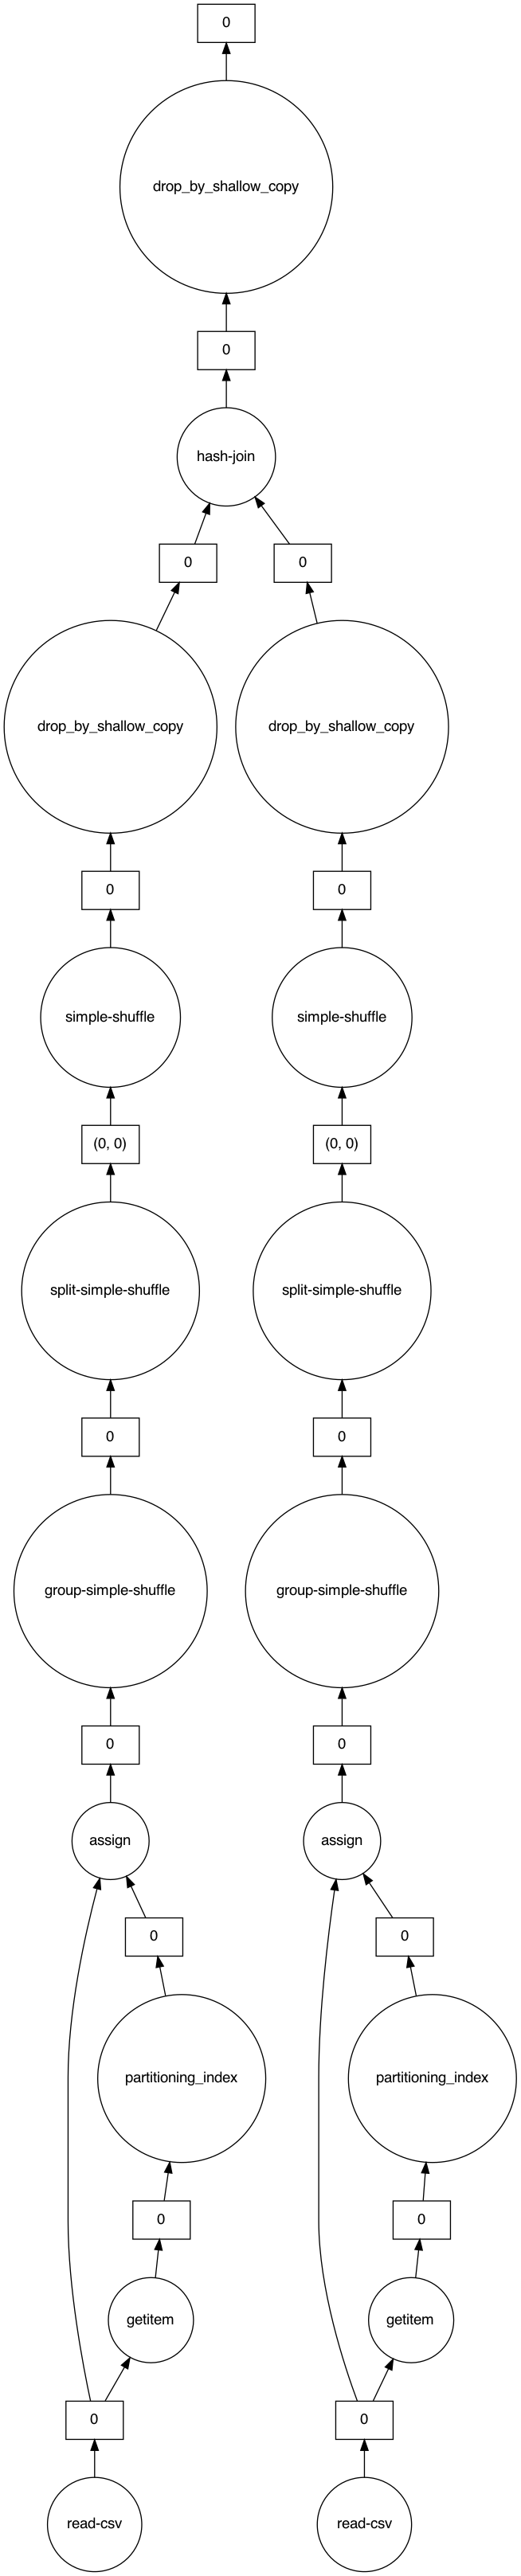

In [30]:
protpep.visualize()

In [31]:
merged_df = dd.merge(left=protpep,right=clinical,how='outer',on="visit_id")

In [32]:
#take a look at the data and identify what needs to be done to prepare for ML
merged_df.columns

Index(['visit_id', 'visit_month_x', 'patient_id_x', 'UniProt_x', 'Peptide',
       'PeptideAbundance', 'UniProt_y', 'NPX', 'patient_id', 'visit_month',
       'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
       'upd23b_clinical_state_on_medication'],
      dtype='object')

In [33]:
merged_df.dtypes

visit_id                                object
visit_month_x                            int64
patient_id_x                             int64
UniProt_x                               object
Peptide                                 object
PeptideAbundance                       float64
UniProt_y                               object
NPX                                    float64
patient_id                               int64
visit_month                              int64
updrs_1                                float64
updrs_2                                float64
updrs_3                                float64
updrs_4                                float64
upd23b_clinical_state_on_medication     object
dtype: object

In [34]:
cleaned_df = merged_df.drop(columns=["visit_month","patient_id"])

In [38]:
cleaned_df.shape

(Delayed('int-9c85eba1-8380-4e25-87b4-067e442eabab'), 13)

In [35]:
cleaned_df.head()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 822.51 MiB -- Worker memory limit: 1.00 GiB
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ("('hash-join-717d5f3ee3fc2b52c27d1984f4c2f747', 0)", <WorkerState 'tcp://127.0.0.1:61959', name: 1, status: closed, memory: 0, processing: 1>)

In [39]:
cleaned_df = pd.get_dummies(cleaned_df, columns=["visit_id","UniProt_x","Peptide","UniProt_y","upd23b_clinical_state_on_medication"])

ValueError: The truth value of a DataFrame is ambiguous. Use a.any() or a.all().

In [ ]:
# PCA

X = #cleaned data will go here
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

In [ ]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

In [ ]:
# plot PCs and dendrogram

In [40]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
